In [37]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import random
from numpy.fft import fft, fftshift
import statistics 
import h5py
from scipy.optimize import curve_fit
from scipy.signal import welch
# from qiskit.visualization import array_to_latex
import h5py

from experiments.single_qubit.single_shot import hist 


In [40]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import random
from numpy.fft import fft, fftshift
import statistics 
import h5py
from scipy.optimize import curve_fit
from scipy.signal import welch

# Load the Data

In [52]:
def load_dataset(dataset_path):
    datasets = {}
    with h5py.File(dataset_path, 'r') as file:
        for key in file.keys():
            datasets[key] = np.array(file[key][...])
    return datasets

# Specify the dataset path
dataset_path = "C:\\_Lib\\python\\rfsoc\\elaine_rfsoc\\slab_rfsoc_expts\\data\\00031_single_shot_qubit0.h5"

# Load dataset
datasets = load_dataset(dataset_path)

# Access each dataset by its key
for key, value in datasets.items():
    print("Key:", key)

Ie = datasets["Ie"]
Ig = datasets["Ig"]
Qe = datasets["Qe"]
Qg = datasets["Qg"]

Key: Ie
Key: Ig
Key: Qe
Key: Qg


# Histogram the Data

Unrotated:
Ig -1.6420047732696896 +/- 4.030630090078519 	 Qg -2.6914732045996965 +/- 3.9508775423429845 	 Amp g 3.152809490996658
Ie -15.271859405510956 +/- 5.873110454692888 	 Qe 1.9832935560859188 +/- 4.14768821476396 	 Amp e 15.400102046132854
Rotated:
Ig 0.6412385673270695 +/- 4.030630090078519 	 Qg 3.0458918833136925 +/- 3.9508775423429845 	 Amp g 3.112658713232774
Ie 15.20091273590075 +/- 5.873110454692888 	 Qe 2.829143370470618 +/- 4.14768821476396 	 Amp e 15.461946844273765


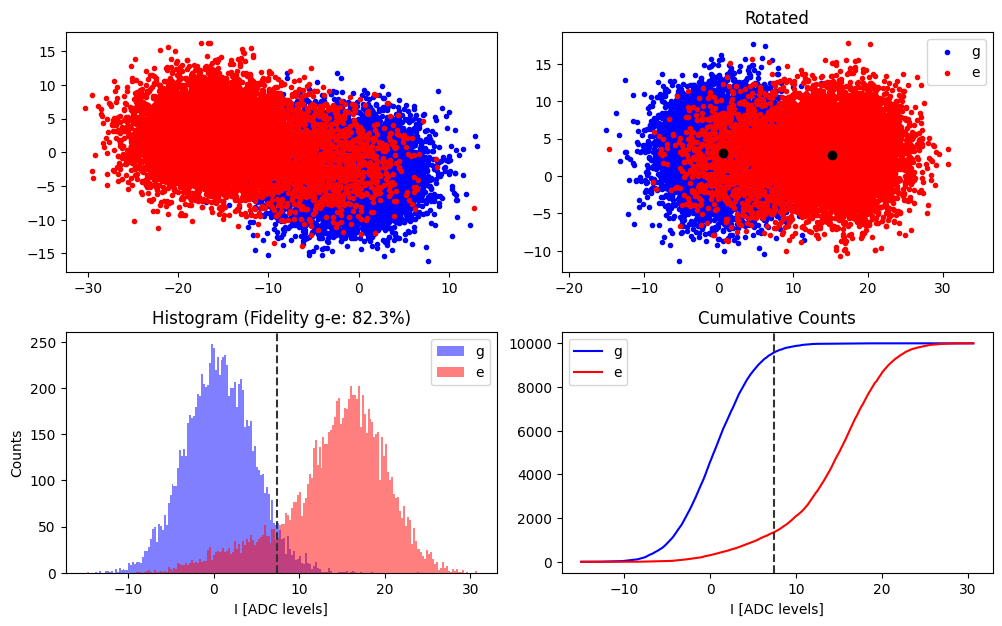

ge fidelity 82.3%
rotation angle -161.0690599901691 (deg)
ge threshold 7.462779763939398


In [53]:
numbins = 200
xg, yg = np.median(Ig), np.median(Qg)
xe, ye = np.median(Ie), np.median(Qe)

print('Unrotated:')
print(f'Ig {xg} +/- {np.std(Ig)} \t Qg {yg} +/- {np.std(Qg)} \t Amp g {np.abs(xg+1j*yg)}')
print(f'Ie {xe} +/- {np.std(Ie)} \t Qe {ye} +/- {np.std(Qe)} \t Amp e {np.abs(xe+1j*ye)}')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fig.tight_layout()

axs[0,0].scatter(Ig, Qg, label='g', color='b', marker='.')
axs[0,0].scatter(Ie, Qe, label='e', color='r', marker='.')


"""Compute the rotation angle"""
theta = -np.arctan2((ye-yg),(xe-xg))

"""Rotate the IQ data"""
Ig_new = Ig*np.cos(theta) - Qg*np.sin(theta)
Qg_new = Ig*np.sin(theta) + Qg*np.cos(theta) 

Ie_new = Ie*np.cos(theta) - Qe*np.sin(theta)
Qe_new = Ie*np.sin(theta) + Qe*np.cos(theta)

"""New means of each blob"""
xg, yg = np.median(Ig_new), np.median(Qg_new)
xe, ye = np.median(Ie_new), np.median(Qe_new)

print('Rotated:')
print(f'Ig {xg} +/- {np.std(Ig)} \t Qg {yg} +/- {np.std(Qg)} \t Amp g {np.abs(xg+1j*yg)}')
print(f'Ie {xe} +/- {np.std(Ie)} \t Qe {ye} +/- {np.std(Qe)} \t Amp e {np.abs(xe+1j*ye)}')

span = (np.max(np.concatenate((Ie_new, Ig_new))) - np.min(np.concatenate((Ie_new, Ig_new))))/2
xlims = [(xg+xe)/2-span, (xg+xe)/2+span]
ylims = [yg-span, yg+span]

axs[0,1].scatter(Ig_new, Qg_new, label='g', color='b', marker='.')
axs[0,1].scatter(Ie_new, Qe_new, label='e', color='r', marker='.')
axs[0,1].scatter(xg, yg, color='k', marker='o')
axs[0,1].scatter(xe, ye, color='k', marker='o')    

# axs[0,1].set_xlabel('I [ADC levels]')
axs[0,1].legend(loc='upper right')
axs[0,1].set_title('Rotated')
axs[0,1].axis('equal')

"""X and Y ranges for histogram"""

ng, binsg, pg = axs[1,0].hist(Ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
ne, binse, pe = axs[1,0].hist(Ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)

axs[1,0].set_ylabel('Counts')
axs[1,0].set_xlabel('I [ADC levels]')       
axs[1,0].legend(loc='upper right')

"""Compute the fidelity using overlap of the histograms"""
fids = []
thresholds = []
contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
tind=contrast.argmax()
thresholds.append(binsg[tind])
fids.append(contrast[tind])

    
axs[1,0].set_title(f'Histogram (Fidelity g-e: {100*fids[0]:.3}%)')
axs[1,0].axvline(thresholds[0], color='0.2', linestyle='--')

axs[1,1].set_title('Cumulative Counts')
axs[1,1].plot(binsg[:-1], np.cumsum(ng), 'b', label='g')
axs[1,1].plot(binse[:-1], np.cumsum(ne), 'r', label='e')
axs[1,1].axvline(thresholds[0], color='0.2', linestyle='--')

axs[1,1].legend()
axs[1,1].set_xlabel('I [ADC levels]')

plt.subplots_adjust(hspace=0.25, wspace=0.15)        
plt.show()


print(f'ge fidelity {100*fids[0]:.3}%' )
print(f'rotation angle {theta*180/np.pi} (deg)')
print(f'ge threshold {thresholds[0]}')

# Confusion Matrix 

Filter the data

In [54]:
def filter_values_less_than_threshold(array, threshold):
    # Find indices of values less than the threshold
    indicies = np.where(array < threshold)
    
    # Extract values less than the threshold
    values_less_than_threshold = array[indicies]
    
    return values_less_than_threshold

def filter_values_greater_than_threshold(array, threshold):
    # Find indices of values less than the threshold
    indicies = np.where(array > threshold)
    # Extract values less than the threshold
    values_greater_than_threshold = array[indicies]
    
    return values_greater_than_threshold




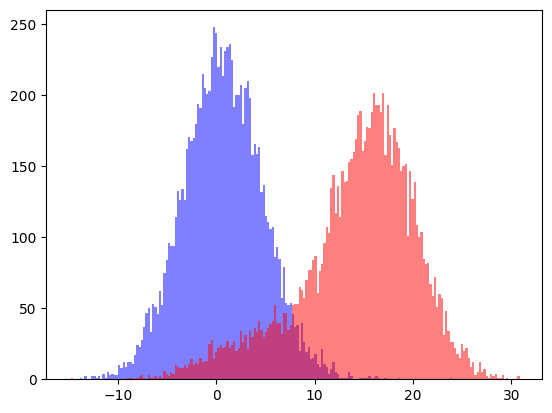

In [55]:
# Call the function to filter values less than the threshold

ng, binsg, pg = plt.hist(Ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
ne, binse, pe = plt.hist(Ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
plt.show()

threshold = thresholds[0]
left_blue = filter_values_less_than_threshold(Ig_new, threshold)
left_red = filter_values_less_than_threshold(Ie_new, threshold)

right_red = filter_values_greater_than_threshold(Ie_new, threshold)
right_blue = filter_values_greater_than_threshold(Ig_new, threshold)


Define the confusion matrix

In [57]:
# confusion = np.array([
#     [len(left_blue)/(len(left_blue) + len(left_red)), len(left_red)/(len(left_blue) + len(left_red))],
#     [len(right_blue)/(len(right_blue) + len(right_red)), len(right_red)/(len(right_blue) + len(right_red))]
# ])

confusion = np.array([
    [len(left_blue)/(len(left_blue) + len(right_blue)), len(left_red)/(len(left_red) + len(right_red))],
    [len(right_blue)/(len(left_blue) + len(right_blue)), len(right_red)/(len(right_red) + len(left_red))]
])

print('Confusion matrix is:\n', confusion, '\n')

inverse_confusion = np.linalg.inv(confusion)

print('Inverse confusion matrix is:\n', inverse_confusion, '\n')
# print(np.sum(inverse_confusion_normal))


Confusion matrix is:
 [[0.9533 0.1319]
 [0.0467 0.8681]] 

Inverse confusion matrix is:
 [[ 1.05685415 -0.1605795 ]
 [-0.05685415  1.1605795 ]] 



# Apply the Confusion Matrix to Data

Import the data

In [58]:
# Open the HDF5 file in read mode
filename =  "C:\\_Data\\LLqub_contT1\\2024-02-20_18-46-50.h5"
hf = h5py.File(filename, 'r')
# Initialize dictionaries to store datasets
datasets_t1_cont = {}
datasets_t1_recal = {}
# Loop through each group and store datasets in dictionaries
for group_name in hf.keys():
    group = hf[group_name]
    datasets_group = {}
    for dataset_name in group.keys():
        datasets_group[dataset_name] = np.array(group[dataset_name])
    if group_name == 't1_cont':
        datasets_t1_cont = datasets_group
    elif group_name == 't1_recal':
        datasets_t1_recal = datasets_group
# Close the HDF5 file
hf.close()

C:\Users\slab\AppData\Local\Temp\ipykernel_18368\2924201763.py:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  datasets_group[dataset_name] = np.array(group[dataset_name])


In [59]:
amp_data =datasets_t1_cont['amp']
q_data = datasets_t1_cont['q']
i_data = datasets_t1_cont['i']
length_array = len(amp_data)


In [60]:
pi_sigma = 0.05889005791993152 # [us]
T1 = 102.81912731303517 #[us]  ## FIX LATER --> MAKE IT THE ACTUAL T1 VALUE GIVEN DATA
readout_length = 15 # [us]
relax_delay = 1500 #[us]

pulse_length = 4*pi_sigma + T1 + readout_length + relax_delay # pulse length [us]
scan_length = length_array * pulse_length *(1E-6) * (1/3600) # length of scan [hr]


print(f'length of pulse {pulse_length} [us]')
print(f'length of scan {scan_length} [hr]')

length of pulse 1618.0546875447149 [us]
length of scan 16.18054687544715 [hr]


Plot the Initial I and Q data 

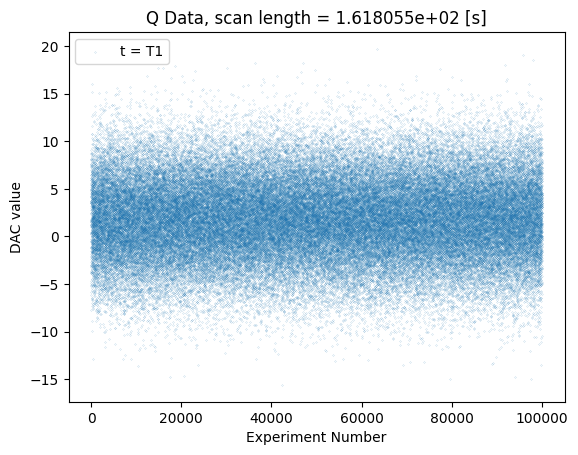

Text(0.5, 1.0, 'I Data, scan length = 1.618055e+02 [s]')

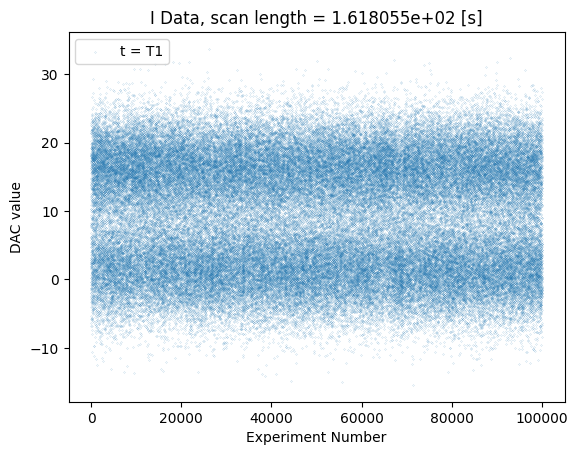

In [61]:
x_data = np.arange(q_data.size)
length_short_scan = 100000
plt.scatter(x_data[0:length_short_scan], q_data[0:length_short_scan], s = 0.009, label = 't = T1')
plt.xlabel('Experiment Number')
plt.ylabel('DAC value')
plt.legend()
plt.title(f'Q Data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')
plt.show()
plt.scatter(x_data[0:length_short_scan], i_data[0:length_short_scan], s = 0.009, label = 't = T1')
plt.xlabel('Experiment Number')
plt.ylabel('DAC value')
plt.legend()
plt.title(f'I Data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')

First, rotate the data 

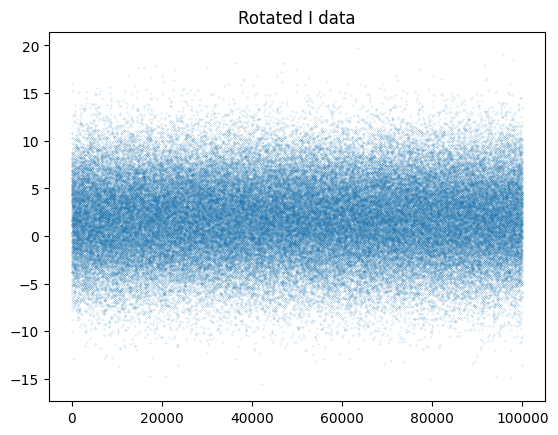

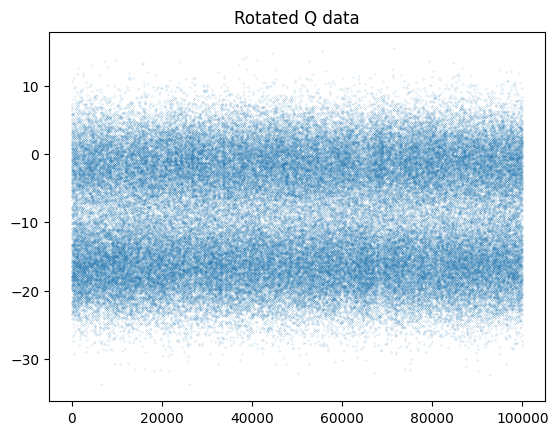

In [67]:
"""Rotate the IQ data"""
angle = theta*np.pi/180 + np.pi
angle = 0 + np.pi # data already rotated
I_new = i_data[0:length_short_scan]*np.sin(angle) - q_data[0:length_short_scan]*np.cos(angle)
Q_new = i_data[0:length_short_scan]*np.cos(angle) + q_data[0:length_short_scan]*np.sin(angle)

plt.scatter(x_data[0:length_short_scan], I_new, s = 0.009)
plt.title('Rotated I data')
plt.show()

plt.scatter(x_data[0:length_short_scan], Q_new, s = 0.009)
plt.title('Rotated Q data')
plt.show()

Then, threshold the rotated data 

In [68]:
def filter_values_less_than_threshold(array, threshold):
    indicies = np.where((array) < (threshold))
    values_less_than_threshold = array[indicies]
    
    return values_less_than_threshold, indicies

def filter_values_greater_than_threshold(array, threshold):
    indicies = np.where((array) > (threshold))
    values_greater_than_threshold = array[indicies]
    
    return values_greater_than_threshold, indicies

# Call the function to filter values less than the threshold
threshold = thresholds[0]

I_new = i_data[0:length_short_scan]

I_g, indicies_ig = filter_values_less_than_threshold(I_new, threshold )
I_e, indicies_ie = filter_values_greater_than_threshold(I_new, threshold )


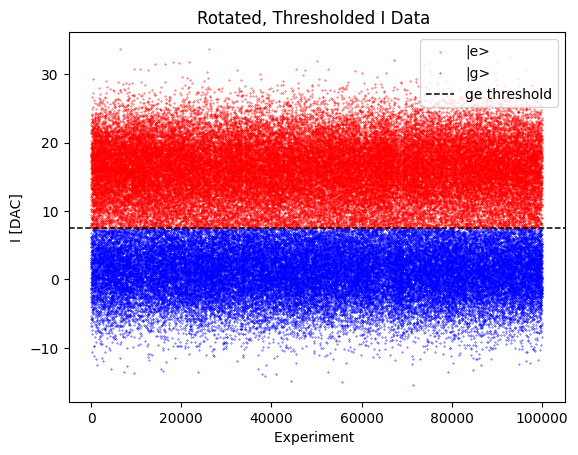

In [69]:
plt.scatter(x_data[indicies_ie], I_e, s= 0.09, color = 'red', label = '|e>')
plt.scatter(x_data[indicies_ig], I_g, s= 0.09, color = 'blue', label = '|g>')
plt.axhline(threshold, color = 'black', linestyle = '--', label = 'ge threshold', linewidth = 1.1)
plt.xlabel('Experiment ')
plt.ylabel('I [DAC]')
plt.legend()
plt.title('Rotated, Thresholded I Data ')
plt.show()


Apply the confusion matrix to the rotated data 

Question: should I round this so that it's physical?

In [70]:
measured_ge = np.array([len(I_g), len(I_e)]).reshape(-1, 1)
print(f'Measured in |g>: {measured_ge[0][0]}\nMeasured in|e>: {measured_ge[1][0]}\n')
print(f'Total number of shots: {np.sum(measured_ge)}', '\n')
# print('Inverse Confusion Matrix\n', inverse_confusion, '\n')

corrected_ge = np.dot((inverse_confusion), measured_ge)
scaled_corrected_ge = corrected_ge * np.sum(measured_ge) / np.sum(corrected_ge)

print(f'Corrected in |g>: {np.round(scaled_corrected_ge[0][0]):.0f}\nCorrected in |e>: {np.round(scaled_corrected_ge[1][0]):.0f}\n')

# print(f'Total number of shots after correction: {np.sum(np.round(scaled_corrected_ge)):.0f}')


Measured in |g>: 44896
Measured in|e>: 55104

Total number of shots: 100000 

Corrected in |g>: 38600
Corrected in |e>: 61400



In [71]:
percent_ground = ((scaled_corrected_ge[0])/(length_short_scan))*100
percent_excited = ((scaled_corrected_ge[1])/(length_short_scan))*100

print(f'Percent in |e> at t = T1: {percent_excited[0]:.1f}%')
print(f'Percent in |g> at t = T1: {percent_ground[0]:.1f}%')


Percent in |e> at t = T1: 61.4%
Percent in |g> at t = T1: 38.6%


## Histogram the |g> and |e> Blobs

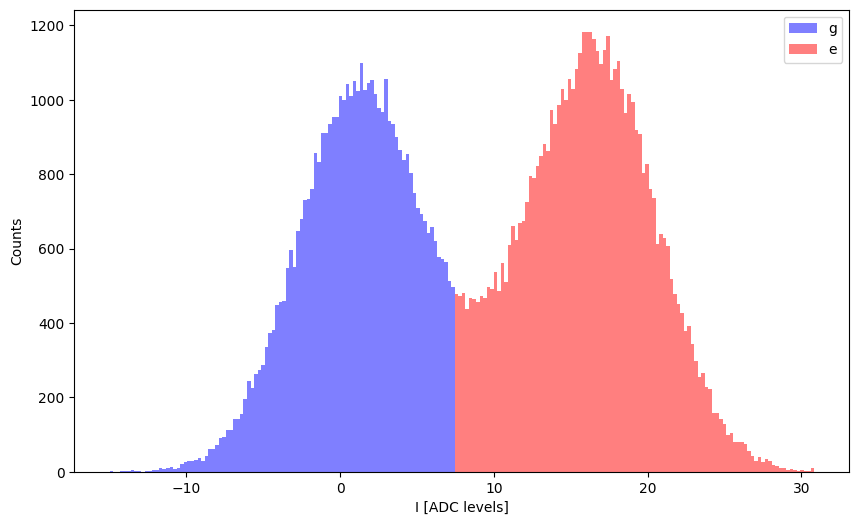

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))


ng, binsg, pg = axs.hist(I_g, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
ne, binse, pe = axs.hist(I_e, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)



axs.set_ylabel('Counts')
axs.set_xlabel('I [ADC levels]')       
axs.legend(loc='upper right')

plt.show()